In [1]:
import numpy as np                   # linear algebra tools
import pandas as pd                  # data manipulation
import scanpy as sc                  # scRNA-seq tools
import anndata as ad                 # scRNA-seq data structures
from scipy.io import mmread          # read .mtx files
import matplotlib.pyplot as plt      # matplotlib
from scipy.sparse import csr_matrix  # sparse matrices
import scanpy.external as sce

# Load basic libraries
import os
import random
import warnings

In [4]:
print(BASE_DIR)

/Users/marinaesteban-medina/ETH_AI/Master-semester_projects/Foundation_models/


In [3]:
### Load ech piece of the anData object
BASE_DIR = os.path.expanduser("~/ETH_AI/Master-semester_projects/Foundation_models/")

# Ensure results/figures directory exists
os.makedirs(f"{BASE_DIR}/figures/preprocess", exist_ok=True)

# Set figure save directory
sc.settings.figdir = f"{BASE_DIR}/figures/preprocess"

# Set seeds
seed = 42
np.random.seed(seed)
random.seed(seed)


In [46]:

# raw counts 
RNA_counts = mmread(f"{BASE_DIR}/data/raw/raw_counts_NB.bone.Met.mtx").transpose().tocsr().astype('float64')

# cell metadata
cell_metadata = pd.read_csv(f'{BASE_DIR}/data/raw/cells_NB.bone.Met.csv') \
                  .rename(columns={'Cell_ID': 'cell'}) \
                  .set_index('cell', drop=False)

cell_names = pd.read_csv(f'{BASE_DIR}/data/raw/cells_NB.bone.Met.csv').set_index('cell', drop=False)
# gene metadata
gene_names = pd.read_csv(f'{BASE_DIR}/data/raw/genes_NB.bone.Met.csv').set_index('gene', drop=False)
gene_mapping_table = pd.read_csv(f'{BASE_DIR}/data/raw/gene_mapping_NB.bone.Met.raw.csv').set_index('hgnc_symbol', drop=False)

# annotation metadata
annotation_metadata = pd.read_csv(f'{BASE_DIR}/data/raw/annotations_NB.bone.Met.csv', index_col = 0).set_index('cell_ID', drop=False)


In [47]:
### Now mount the anData object
layers_dict = {'RNA': RNA_counts}

adata = ad.AnnData(
    X=layers_dict['RNA'], 
    obs=annotation_metadata, 
    var=gene_mapping_table, 
    layers=layers_dict, 
    # obsm=dimred_dict, 
    # obsp=graph_dict, 
    # uns=uns_dict
)
adata

AnnData object with n_obs × n_vars = 37265 × 31709
    obs: 'cell1', 'cell2', 'fraction', 'sample', 'cell_ID'
    var: 'hgnc_symbol', 'ensembl_gene_id', 'gene_biotype'
    layers: 'RNA'

In [ ]:
# Filtering cells with low gene-counts and genes with low cell-counts as low quality
adata = adata[:, adata.var_names != 'MALAT1'] ## remove MALAT1 as it is  a known singele-cell RNA-seq artifact
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

/opt/homebrew/Caskroom/mambaforge/base/envs/scdef_env/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:167: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_genes"] = number


In [ ]:
# Normalization and scaling
scaled_counts = sc.pp.normalize_total(adata, target_sum=None, inplace=False)
adata.layers["log1p_norm"] = sc.pp.log1p(scaled_counts["X"], copy=True)
adata.X = adata.layers["log1p_norm"] ## We will use this as the main matrix accessed by adata.X 
sc.pp.scale(adata, max_value=10)

In [ ]:
# Initial UMAP and clustering to do a quick check of our data structure
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata, flavor='igraph', n_iterations=2)
adata

/opt/homebrew/Caskroom/mambaforge/base/envs/scdef_env/lib/python3.9/site-packages/scanpy/tools/_utils.py:41: UserWarning: You’re trying to run this on 25139 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  warnings.warn(


AnnData object with n_obs × n_vars = 36763 × 25139
    obs: 'cell1', 'cell2', 'fraction', 'sample', 'cell_ID', 'n_genes', 'leiden'
    var: 'hgnc_symbol', 'ensembl_gene_id', 'gene_biotype', 'n_cells', 'mean', 'std'
    uns: 'pca', 'neighbors', 'umap', 'leiden'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'RNA', 'log1p_norm'
    obsp: 'distances', 'connectivities'

In [6]:
adata = sc.read(f"{BASE_DIR}/data/preprocess/NB.bone.Met_preprocessed.h5ad")
adata

Only considering the two last: ['.Met_preprocessed', '.h5ad'].
Only considering the two last: ['.Met_preprocessed', '.h5ad'].


AnnData object with n_obs × n_vars = 36763 × 25139
    obs: 'cell1', 'cell2', 'fraction', 'sample', 'cell_ID', 'n_genes', 'leiden'
    var: 'hgnc_symbol', 'ensembl_gene_id', 'gene_biotype', 'n_cells', 'mean', 'std'
    uns: 'leiden', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'RNA', 'log1p_norm'
    obsp: 'connectivities', 'distances'

In [52]:
adata.write(f"{BASE_DIR}/data/preprocess/NB.bone.Met_preprocessed.h5ad")

In [31]:
# Save initial UMAP plots
for feature in ["cell1", "cell2", "fraction", "sample"]:
    sc.pl.umap(adata, color=feature, show=False, save=f"_initial_{feature}.png")

In [ ]:
# Batch effect removal (we need to remove the variability that is due to the experiment setup and not the biology behinnd it)
sce.pp.harmony_integrate(adata, 'sample')
adata.obsm['X_pca'] = adata.obsm['X_pca_harmony']

# Here we recompute the neighbors and umap to visualize if the batch effect was removed
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata, flavor='igraph', n_iterations=2)

2025-03-24 19:16:31,634 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-03-24 19:16:35,263 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-03-24 19:16:35,349 - harmonypy - INFO - Iteration 1 of 10
2025-03-24 19:16:42,106 - harmonypy - INFO - Iteration 2 of 10
2025-03-24 19:16:49,137 - harmonypy - INFO - Iteration 3 of 10
2025-03-24 19:16:55,925 - harmonypy - INFO - Iteration 4 of 10
2025-03-24 19:17:02,095 - harmonypy - INFO - Iteration 5 of 10
2025-03-24 19:17:08,720 - harmonypy - INFO - Iteration 6 of 10
2025-03-24 19:17:14,882 - harmonypy - INFO - Iteration 7 of 10
2025-03-24 19:17:21,563 - harmonypy - INFO - Iteration 8 of 10
2025-03-24 19:17:25,640 - harmonypy - INFO - Iteration 9 of 10
2025-03-24 19:17:29,536 - harmonypy - INFO - Iteration 10 of 10
2025-03-24 19:17:32,827 - harmonypy - INFO - Stopped before convergence


In [35]:
# Save post-Harmony UMAP plots
for feature in ["cell1", "cell2", "fraction", "sample"]:
    sc.pl.umap(adata, color=feature, show=False, save=f"_harmony_{feature}.png")

In [ ]:
adata.write(f'{BASE_DIR}/data/preprocess/NB.bone.Met_harmony.h5ad') ## save the harmony corrected data

In [8]:
adata = sc.read(f"{BASE_DIR}/data/preprocess/NB.bone.Met_harmony.h5ad") # That is how you would read the anData object with scanpy
adata

Only considering the two last: ['.Met_harmony', '.h5ad'].
Only considering the two last: ['.Met_harmony', '.h5ad'].


AnnData object with n_obs × n_vars = 36763 × 25139
    obs: 'cell1', 'cell2', 'fraction', 'sample', 'cell_ID', 'n_genes', 'leiden'
    var: 'hgnc_symbol', 'ensembl_gene_id', 'gene_biotype', 'n_cells', 'mean', 'std'
    uns: 'leiden', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs'
    layers: 'RNA', 'log1p_norm'
    obsp: 'connectivities', 'distances'

In [7]:
print(adata.obs["cell1"].value_counts())
print(adata.obs["cell2"].value_counts())

cell1
T cells            12800
B cells             7475
myeloid             5600
immature B          2011
NK                  1919
proerythroblast     1448
Tumor               1327
Neutrophil          1090
progenitor           959
pro B                899
erythroid            549
pDC                  533
plasma               153
Name: count, dtype: int64
cell2
CTL-1                   6328
Naive B                 4290
Active B                2659
Mono-2                  2531
CD4 naive T             2005
CTL-2                   1925
pre B progenitor        1633
proerythroblast         1448
Tumor                   1327
pro myeloid             1139
CD8 naive T             1117
Mono-1                   988
progenitor               959
Tconv                    954
neutrophils-1            901
Pro-B                    891
CD56bright               569
erythroid                549
CD56dim-1                537
pDC                      533
Memory B                 526
Macro                    523

In [8]:
# 1. Extract DE signature for a known cell type
sc.tl.rank_genes_groups(adata, groupby="cell1", method="wilcoxon")

# 2. Get top 50 marker genes for the cell type of interest
celltype = "NK"
ranked_genes = adata.uns['rank_genes_groups']['names'][celltype][:50]

/opt/homebrew/Caskroom/mambaforge/base/envs/scdef_env/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/opt/homebrew/Caskroom/mambaforge/base/envs/scdef_env/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/opt/homebrew/Caskroom/mambaforge/base/envs/scdef_env/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/opt/homebrew/Caskroom/mambaforge/base/envs/scdef_env/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/opt/homebrew/Caskroom/mambaforge/base/envs/scdef_env/lib/python3.9/site-packages/scanpy/tools/_

In [9]:
ranked_genes

array(['CD7', 'KLRD1', 'NKG7', 'KLRF1', 'CTSW', 'KLRB1', 'PRF1', 'CD247',
       'GNLY', 'CST7', 'GZMA', 'IL2RB', 'TYROBP', 'FCER1G', 'TRDC',
       'GZMB', 'HOPX', 'HCST', 'SRGN', 'JAK1', 'CMC1', 'CLIC3', 'IFITM2',
       'HLA-A', 'GZMM', 'MATK', 'FCGR3A', 'CD63', 'ARL4C', 'B2M', 'PLAC8',
       'TXK', 'ABHD17A', 'PTGDR', 'HLA-C', 'EFHD2', 'CALM1', 'SPON2',
       'KLRC1', 'HLA-B', 'SAMD3', 'ITGB2', 'CCL4', 'PYHIN1', 'RUNX3',
       'CCL5', 'ID2', 'RAP1B', 'ADGRG1', 'XCL2'], dtype=object)

###  Inspecting our data with biological marker genes ###
##### If you’re curious about the biological context of your data, you can inspect specific gene markers to understand which cell types might be present. Marker genes help us interpret clusters and identify known cell populations based on gene expression patterns.

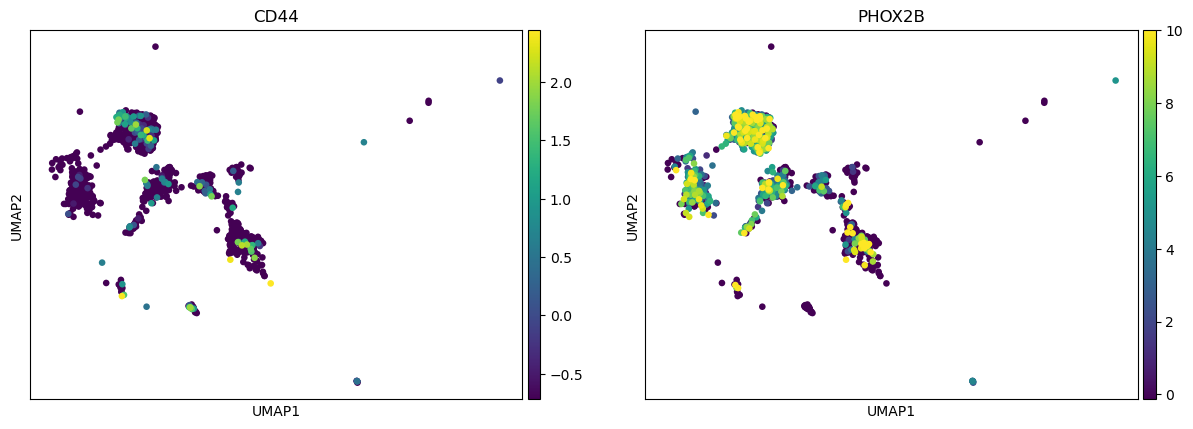

In [55]:
### Check the NOR and ADR signatures in the tumor cells ###

# 1) Subset the AnnData to only include Tumor cells
tumor_adata = adata[adata.obs["cell2"] == "Tumor"].copy()

# 2) Plot the expression of your genes of interest (e.g. "GeneA", "GeneB")
sc.pl.umap(tumor_adata, color=["CD44", "PHOX2B"])

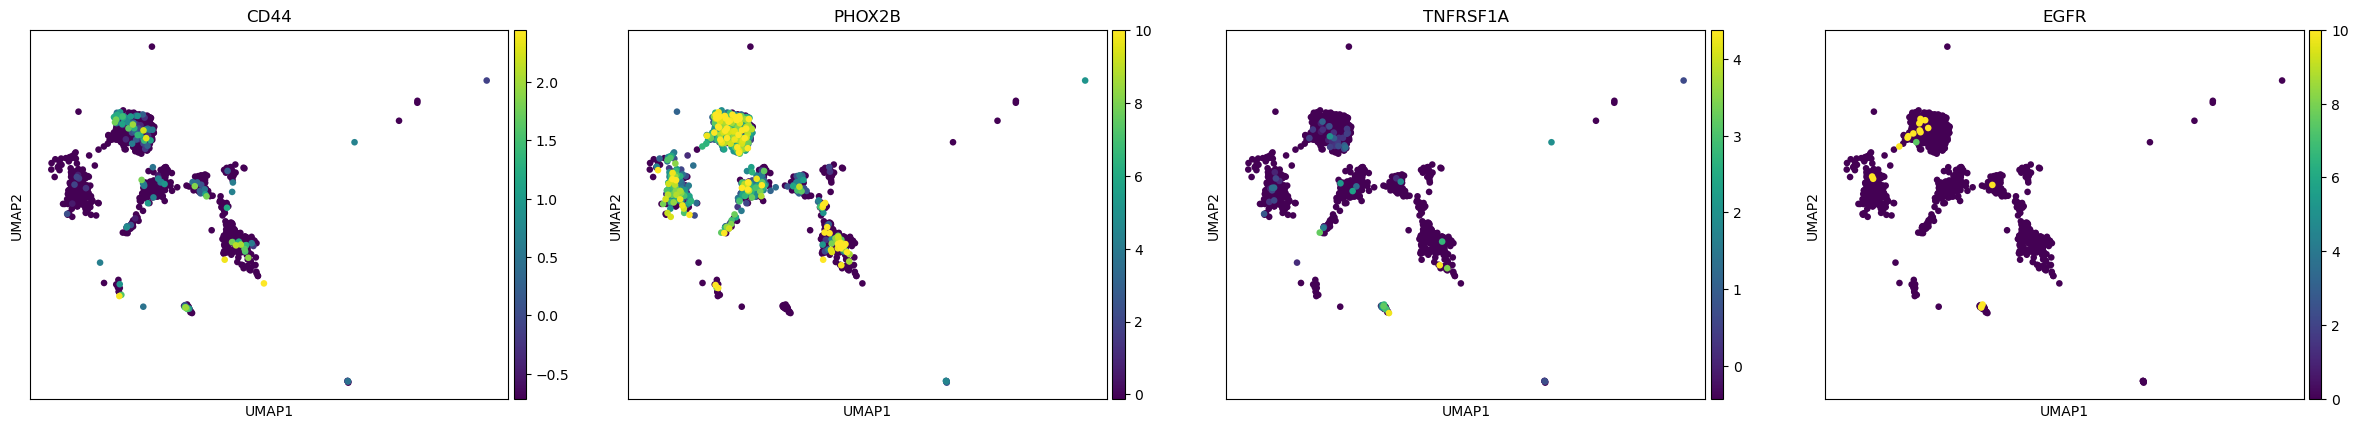

In [ ]:
# 2) Plot the expression of your genes of interest (e.g. "GeneA", "GeneB")

## PHOX2B ADR population
## CD44 MES
## TNFRSF1A AND EGFR Bridge to MES

sc.pl.umap(tumor_adata, color=["CD44", "PHOX2B", "TNFRSF1A", "EGFR"])

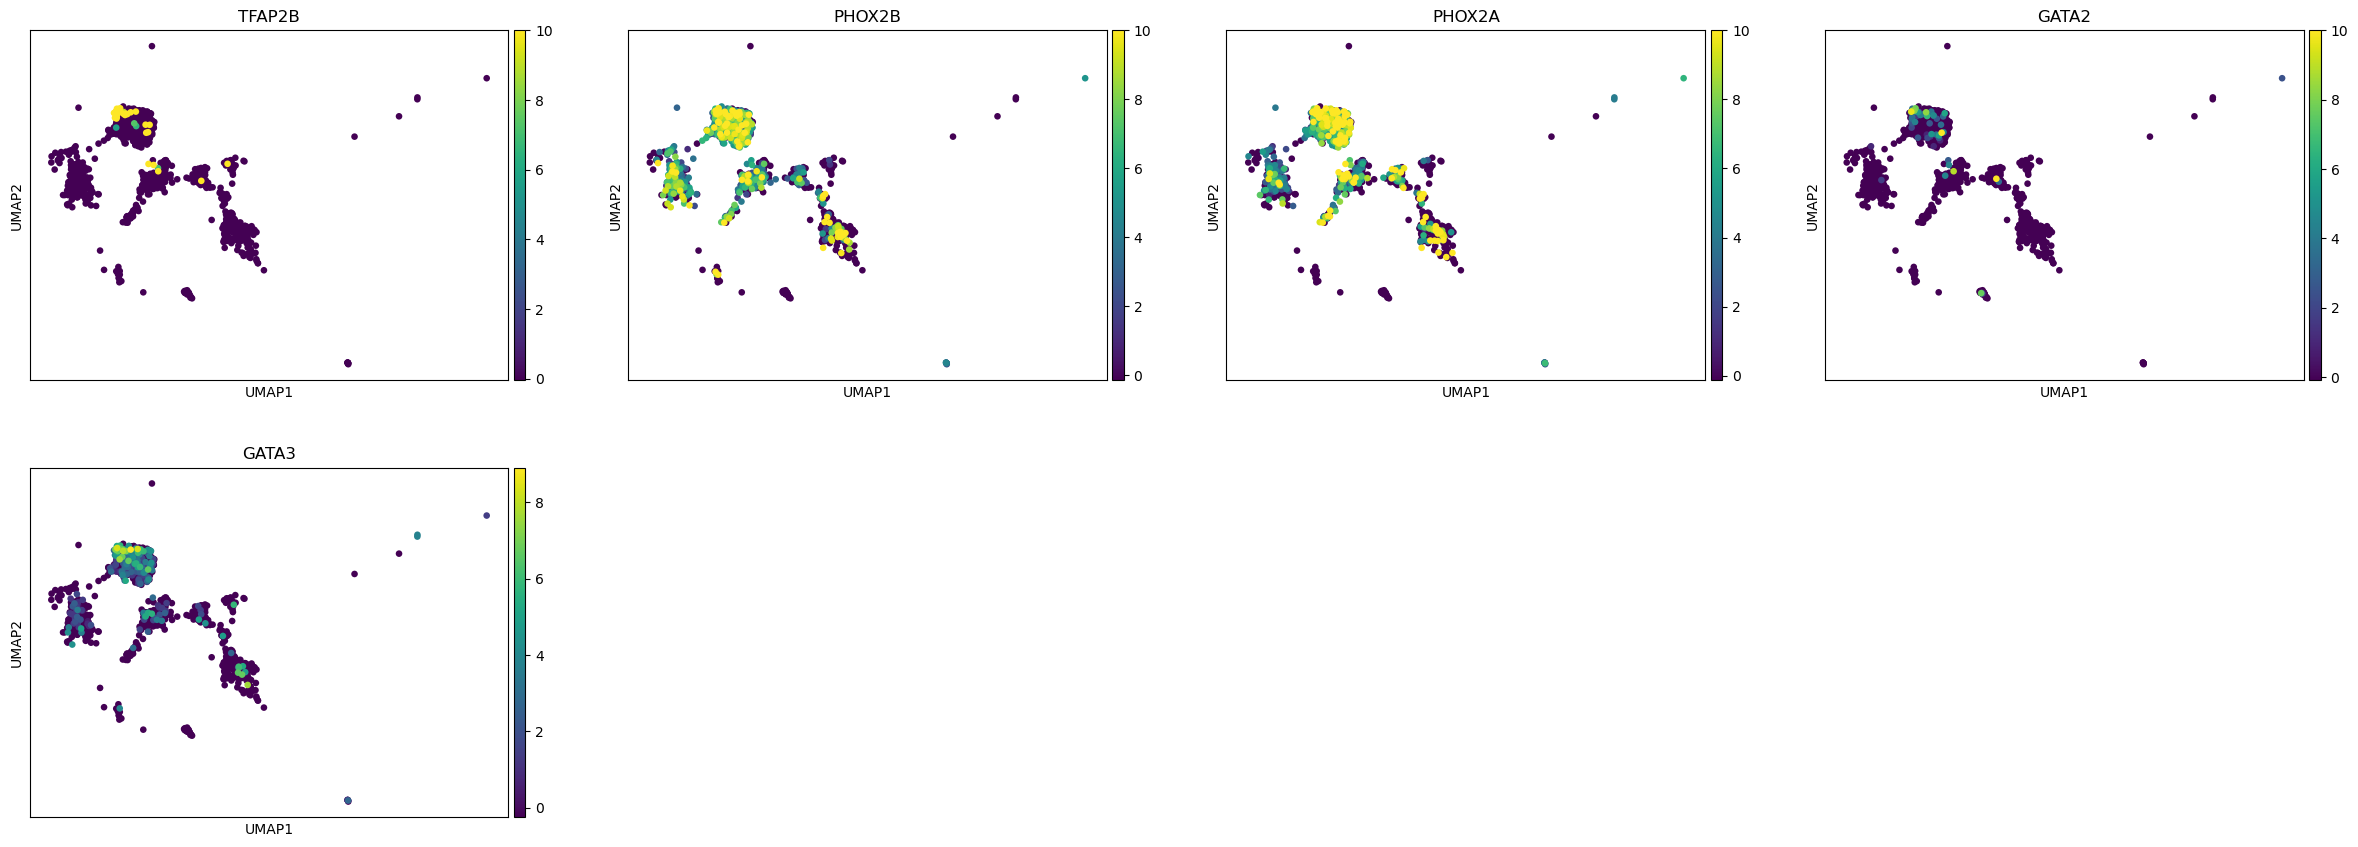

In [ ]:
## NOR genes from https://www.nature.com/articles/s41467-023-38239-5/figures/4
sc.pl.umap(tumor_adata, color=["TFAP2B", "PHOX2B", "PHOX2A", "GATA2", "GATA3"])

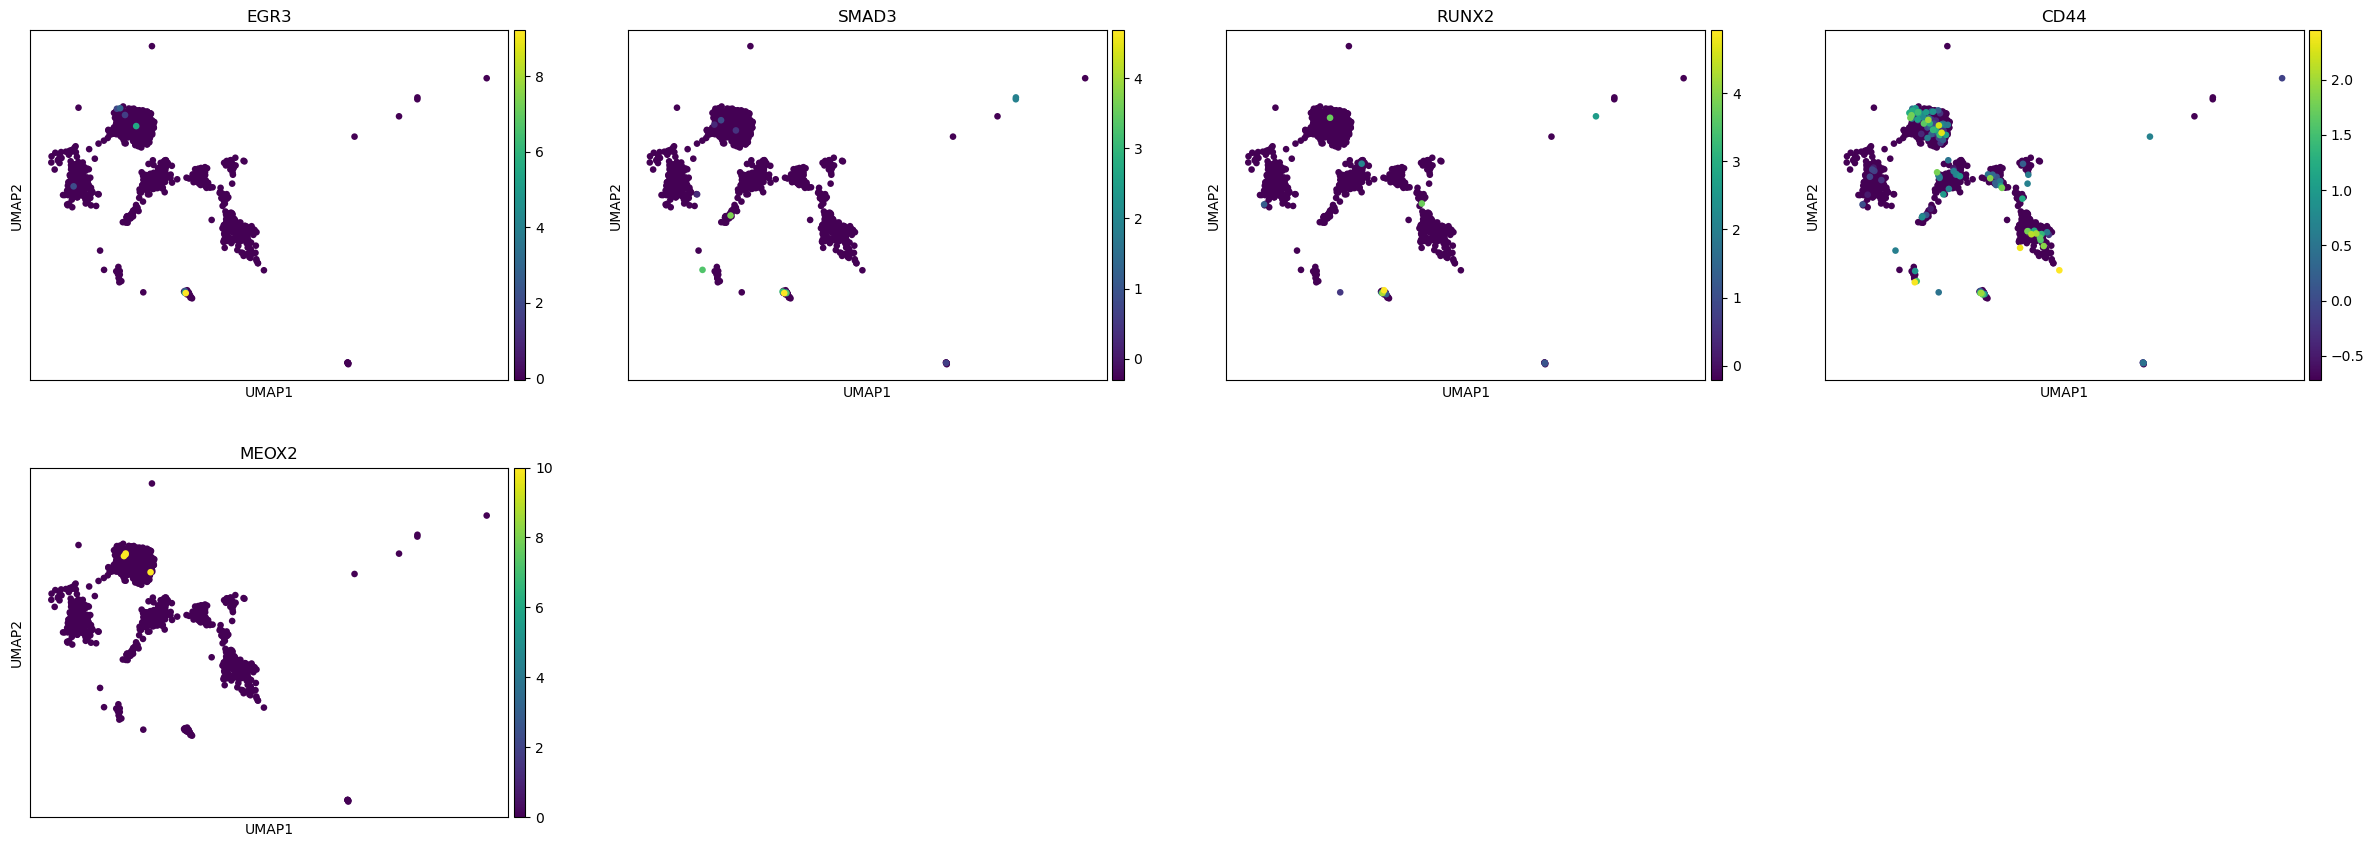

In [64]:
## MES genes from https://www.nature.com/articles/s41467-023-38239-5/figures/4

sc.pl.umap(tumor_adata, color=["EGR3", "SMAD3", "RUNX2", "CD44", "MEOX2"])

## THE END